Step 1: Brief description of the problem and data

This kaggle competition is centered around histopathologic cancer detection. The competition is setup as a binary image classification challenge, with images labelled as either cancerous or not. The dataset contains 220,025 images, of 96 X 96 pixels. The data is validated against 32 X 32 unseen image patches, which are then classified as cancerous or not

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [1]:
import os
import pandas as pd

data_dir = '/kaggle/input/histopathologic-cancer-detection'
train_img_dir = os.path.join(data_dir, 'train')
labels_path = os.path.join(data_dir, 'train_labels.csv')

print(labels_path)
labels_df = pd.read_csv(labels_path)
labels_df = labels_df.drop_duplicates('id')

sample_df = labels_df.sample(n=1000, random_state=42).reset_index(drop=True)
print(sample_df.head())


/kaggle/input/histopathologic-cancer-detection/train_labels.csv
                                         id  label
0  d293308913e4a40cebb809d986aa9add65a76bfa      0
1  fcd55f03496afb4b11598d9c2231e86da318e723      1
2  5c983c8f14afeffdb098b9f3cbb68488a802b957      0
3  71bf03e8530348e57ec07d8ce2052f215390c997      0
4  1533406000e26663c5fadac3bcc3e38285a45bb3      1


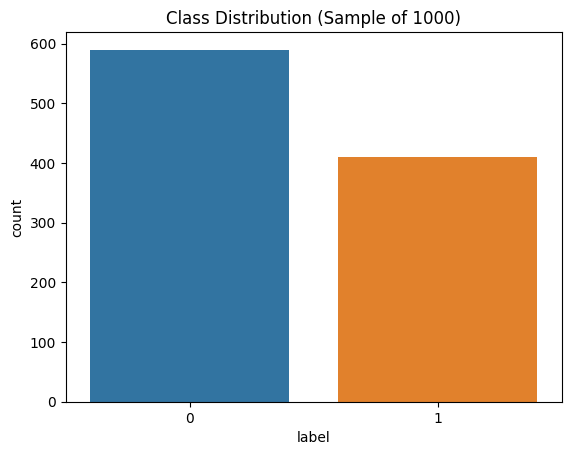

Class Proportions:
 label
0    0.59
1    0.41
Name: proportion, dtype: float64


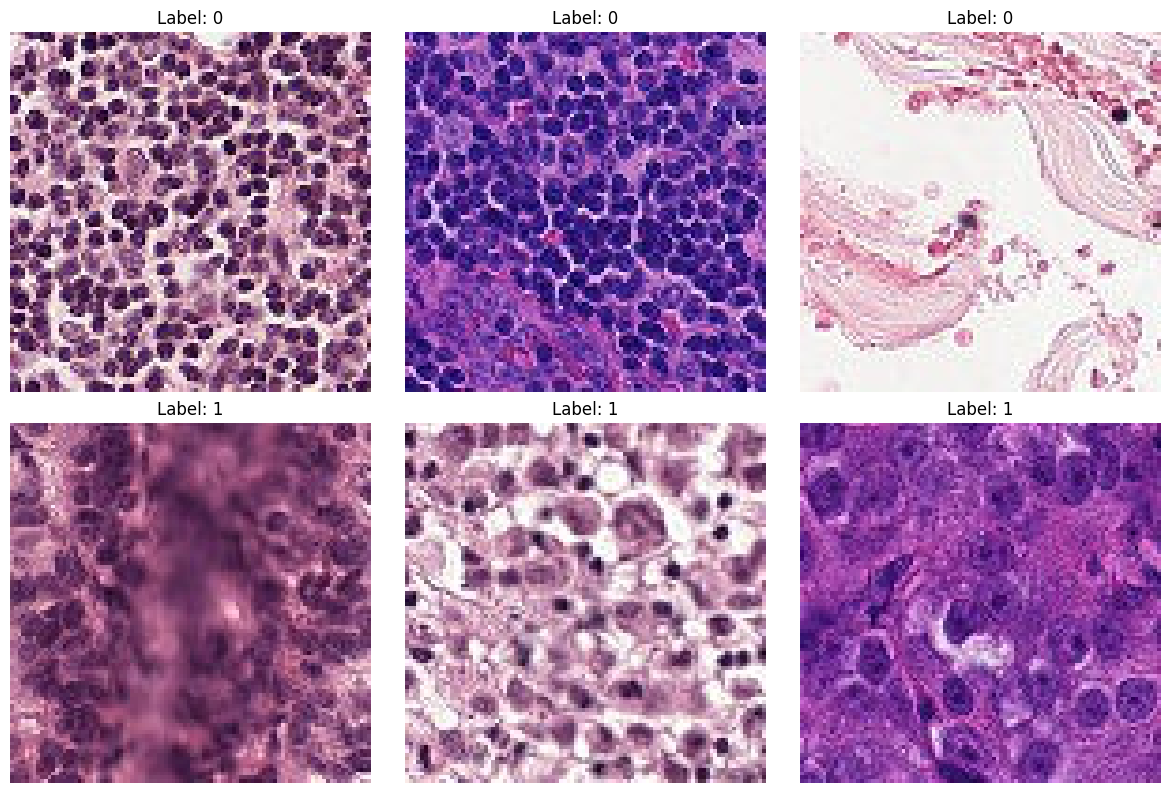

In [6]:
sns.countplot(data=sample_df, x='label')
plt.title('Class Distribution (Sample of 1000)')
plt.show()

label_counts = sample_df['label'].value_counts(normalize=True)
print("Class Proportions:\n", label_counts)

sample_ids = sample_df.sample(6, random_state=10)['id'].values
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, img_id in enumerate(sample_ids):
    img_path = os.path.join(train_img_dir, f"{img_id}.tif")
    img = Image.open(img_path)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].set_title(f"Label: {sample_df.loc[sample_df['id'] == img_id, 'label'].values[0]}")
    axs[i//3, i%3].axis('off')


plt.tight_layout()
plt.show()

Step 3: Model Architecture

The model architecture I will be using is a convolutional neural network, with 3 convolution layers. Each layer will be constructed of a set of 3x3 filtering steps, a ReLu activation step, and a 2x2 max pooling step. Layer 1 will have 32 filters. Layer 2 will have 64 filters. Layer 3 will have 128 filters. This will be followed by a dropout step, and a sigmoid activation step, as that works well for binary class classification. This architecture will work well as the limited number of layers and max pooling steps help to reduce overfitting. The droput step helps with regularization, to keep the model general and portable to different inputs. By comparison, other model architectures, like a transfer-learning architecture are likely to overfit because of the additional depth.

In [8]:
def load_images(df, image_dir):
    images = []
    for img_id in df['id']:
        path = os.path.join(image_dir, f'{img_id}.tif')
        img = Image.open(path).resize((96, 96))
        images.append(np.array(img))
    return np.array(images) / 255.0

X = load_images(sample_df, train_img_dir)
y = sample_df['label'].values

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Step 4: Results and Analysis

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def cnn(dropout_rate=0.5):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [30]:
results = []

def compile_and_train(model, lr, name, epochs=10):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=32, verbose=0)
    
    val_acc = history.history['val_accuracy'][-1]
    results.append({'Model': name, 'Dropout': model.layers[-3].rate, 'LR': lr, 'Val Accuracy': round(val_acc, 4)})
    
    return history

In [31]:
def compile_and_train_sgd(model, lr, name, epochs=10):
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=32, verbose=0)
    
    val_acc = history.history['val_accuracy'][-1]
    results.append({'Model': name, 'Dropout': model.layers[-3].rate, 'LR': lr, 'Val Accuracy': round(val_acc, 4)})
    
    return history

Hyperparameter Optimization: Varying learning rate and dropout

In [32]:
histories = {}

for dropout in [0.3, 0.5]:
    for lr in [1e-3, 1e-4]:
        model = cnn(dropout_rate=dropout)
        name = f'CNN_drop{dropout}_lr{lr}'
        history = compile_and_train(model, lr, name)
        histories[name] = history
        name2 = f'CNN_sgd_drop{dropout}_lr{lr}'
        history2 = compile_and_train_sgd(model, lr, name2)
        histories[name2] = history2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
results_df = pd.DataFrame(results)
print(results_df)

                      Model  Dropout      LR  Val Accuracy
0       CNN_drop0.3_lr0.001      0.3  0.0010         0.765
1   CNN_sgd_drop0.3_lr0.001      0.3  0.0010         0.755
2      CNN_drop0.3_lr0.0001      0.3  0.0001         0.785
3  CNN_sgd_drop0.3_lr0.0001      0.3  0.0001         0.785
4       CNN_drop0.5_lr0.001      0.5  0.0010         0.795
5   CNN_sgd_drop0.5_lr0.001      0.5  0.0010         0.780
6      CNN_drop0.5_lr0.0001      0.5  0.0001         0.735
7  CNN_sgd_drop0.5_lr0.0001      0.5  0.0001         0.780


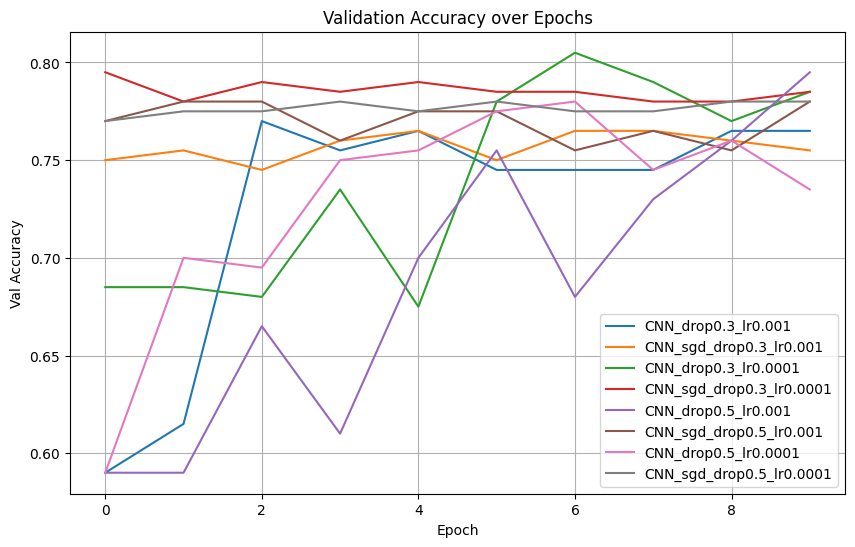

In [34]:
def plot_histories(histories_dict):
    plt.figure(figsize=(10, 6))
    for name, hist in histories_dict.items():
        plt.plot(hist.history['val_accuracy'], label=f'{name}')
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Val Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_histories(histories)

The hyperparameter chosen for the current hyperparameter optimization are relatively similar in the long run, but have different areas of ideal behavior. dropout of 0.3 and lr of 0.0001 is best for both short epochs and long epochs. dropout of 0.5 with both learning rates of 0.001 and 0.0001 are best for the middle-range epoch duration. dropout of 0.3 and learning rate of 0.01 is never the best, and is the worst in most scenarios. The optimizer, adam vs SGD did not have a distinguishable impact on the outcomes at longer epochs, but was substantially better at shorter epochs.

It is likely that this combination of factors (drop: 0.3, lr: 0.001) does not work well as the regularization and learning rate are mismatched - the relatively low dropout rates mean it doesn't generalize as well, but the relatively high learning rate causes overfitting in these scenarios where the regularization isn't high enough.

Step 5: Conclusion

Through experimentation with convolutional neural networks, different combinations of dropout, learning rates, and optimizers, the models have been fit to images of scans both with and without cancer, and trained, with validation accuracy as the primary comparison metric. 

The primary takeaway is that lower learning rates and lower dropout values improved long term validation accuracy for both the adam and sgd optimized convolutional neural networks. Raising dropout or the learning rate did not improve the model. SGD improved the model at low epoch count, but did not affect long term performance by much. 

Future investigations could further expand the hyperparameters explore to a wider range of dropout values and learning rates, optimization techniques, and model architectures, employing different filter combinations or transfer learning models.

In [ ]:
test_img_dir = os.path.join(data_dir, 'test')
test_filenames = sorted(os.listdir(test_img_dir))
test_ids = [fname.split('.')[0] for fname in test_filenames]  # Extract the IDs (without extensions)
df = pd.DataFrame({'id': test_ids})
test_images = load_images(df, test_img_dir)
print('images loaded!')
dropout = 0.3
model = cnn(dropout_rate=dropout)
name = f'CNN_drop{dropout}_lr0.0001'
history = compile_and_train(model, 0.0001, name)
print('model fit')

preds = model.predict(test_images)
pred_labels = (preds > 0.5).astype(int).flatten()
submission = pd.DataFrame({'id': df['id'], 'label': pred_labels})
submission.to_csv('submission.csv', index=False)

